In [1]:
from fastai.vision.all import *

# Multi-Label Classification

## Data

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/storage/data/pascal_2007/valid.json'),Path('/storage/data/pascal_2007/test.csv'),Path('/storage/data/pascal_2007/train.json'),Path('/storage/data/pascal_2007/segmentation'),Path('/storage/data/pascal_2007/test'),Path('/storage/data/pascal_2007/train'),Path('/storage/data/pascal_2007/test.json'),Path('/storage/data/pascal_2007/train.csv')]

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Deeper dive into datablock

In [4]:
dblock = DataBlock()
dsets = dblock.datasets(df)

dsets.train[0]

(fname         004789.jpg
 labels      horse person
 is_valid            True
 Name: 2397, dtype: object,
 fname         004789.jpg
 labels      horse person
 is_valid            True
 Name: 2397, dtype: object)

###### x and y:

In [6]:
dblock = DataBlock(get_x=lambda r: r['fname'], get_y=lambda r: r['labels'].split(' '))
dsets = dblock.datasets(df)

dsets.train[0]

('003373.jpg', ['dog', 'person'])

###### Categories:

In [9]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
    get_x=lambda r: (path/'train')/r['fname'],
    get_y=lambda r: r['labels'].split(' '))

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [10]:
dsets.train.vocab

(#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]

In [13]:
idx = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idx]

(#1) ['cow']

###### Validation set

In [15]:
def splitter(df):
    train = df.index[~df.is_valid].tolist()
    valid = df.index[df.is_valid].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
    get_x=lambda r: (path/'train')/r['fname'],
    get_y=lambda r: r['labels'].split(' '),
    splitter=splitter)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

###### Finally: DataLoaders

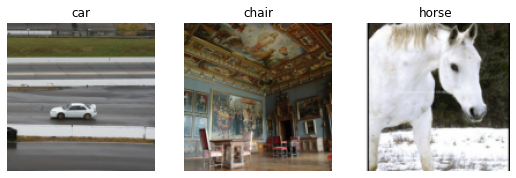

In [16]:
def splitter(df):
    train = df.index[~df.is_valid].tolist()
    valid = df.index[df.is_valid].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
    get_x=lambda r: (path/'train')/r['fname'],
    get_y=lambda r: r['labels'].split(' '),
    splitter=splitter,
    item_tfms=RandomResizedCrop(128, min_scale=.35))

dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)